In [ ]:
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [ ]:
# load data into a Pandas DataFrame
df = pd.read_csv('cardio_train.csv', sep=';',index_col = False).iloc[:, 1:] 
df

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69995,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


In [ ]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.cardio.value_counts()


0    35021
1    34979
Name: cardio, dtype: int64

# Data Cleaning

35,021 out of 70,000 cases in this dataset are labelled as having no cardiovascular disease, and 34,979 cases are labelled as having cardiovascular disease. This suggests that the dataset is roughly balanced.

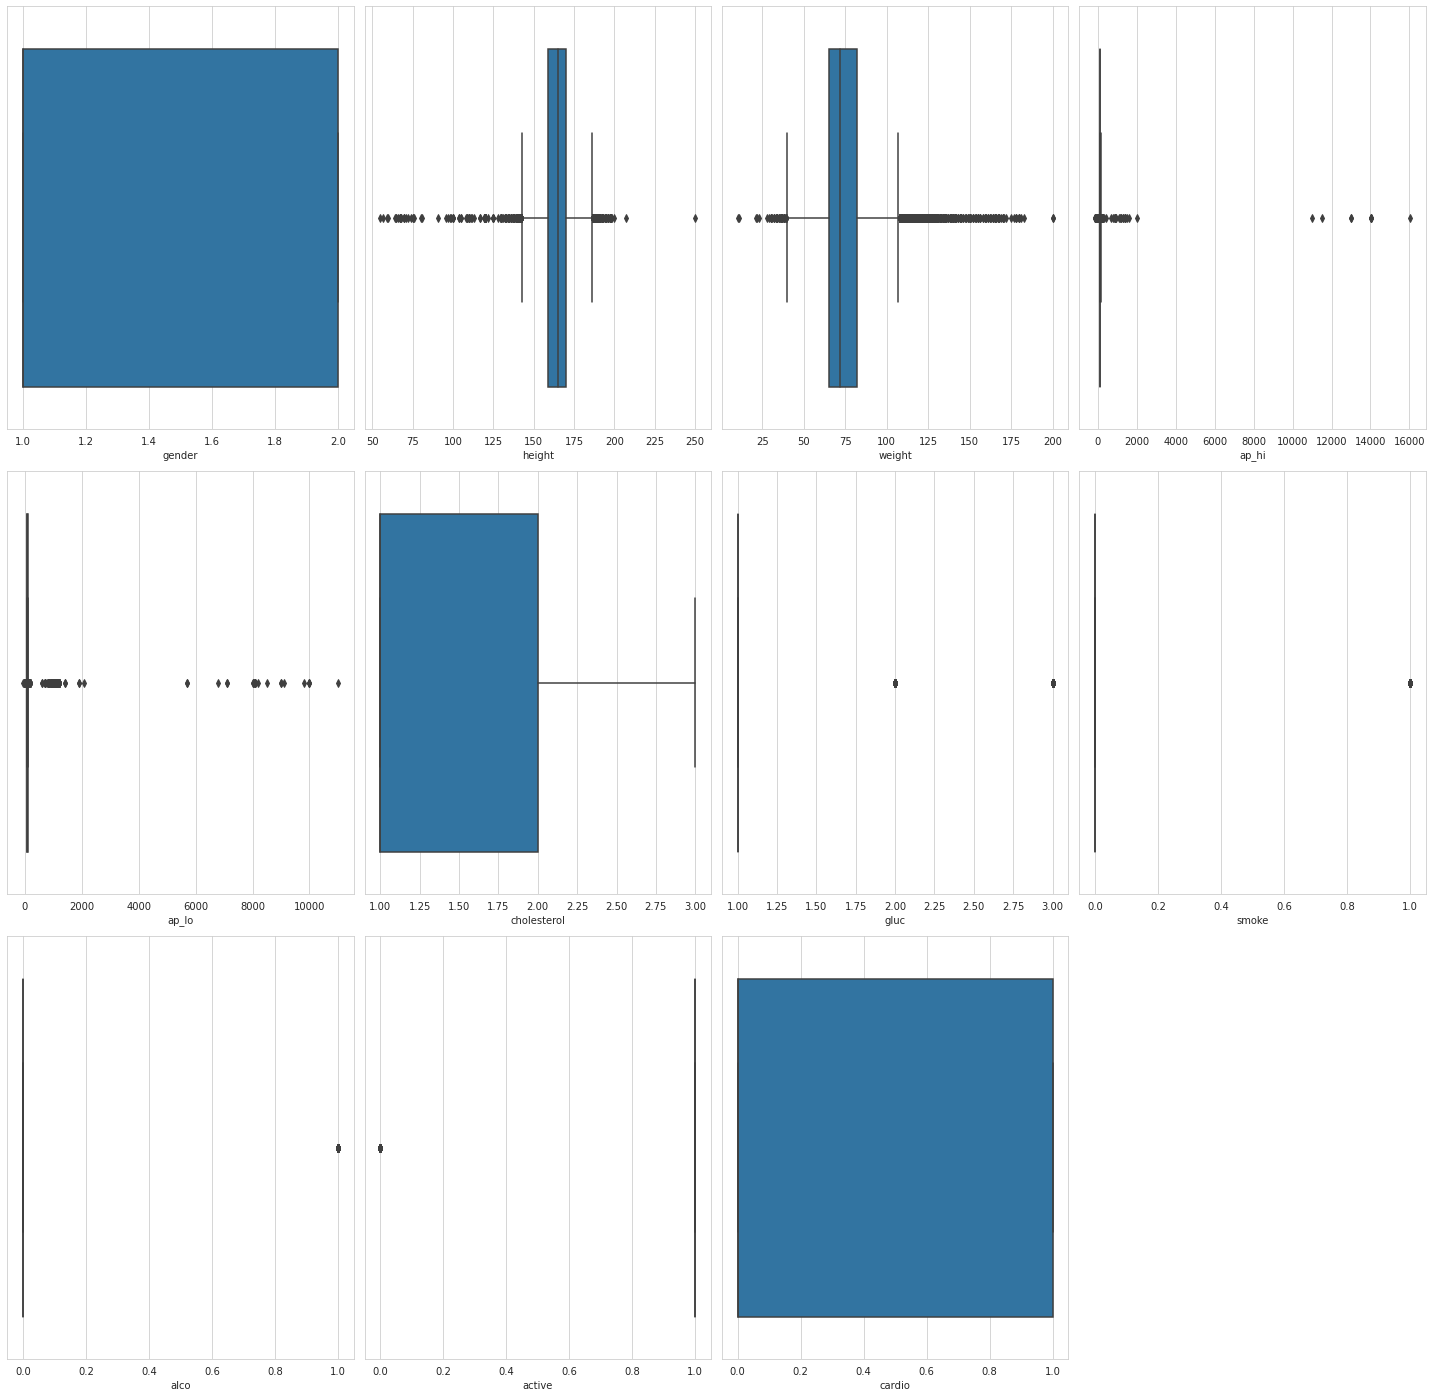

In [ ]:
# check outliers
import warnings
warnings.filterwarnings('ignore')
def check_outliers(df):
  l = df.columns.values
  plt.figure(figsize=(20,32))
  for i in range(1,len(l)):
    plt.plot(figsize=(5,5))
    plt.subplot(5,4,i)
    sns.set_style('whitegrid')
    sns.boxplot(df[l[i]],orient='v')
    plt.tight_layout()
check_outliers(df)

The above boxplots confirm our suspicion that there are outliers in the dataset. There appear to be several outliers in the systolic and diastolic variables (ap_hi and ap_lo). These outliers might be explained by human error when entering data into the .csv format. Our prediction model might benefit if these outliers were removed from the data.

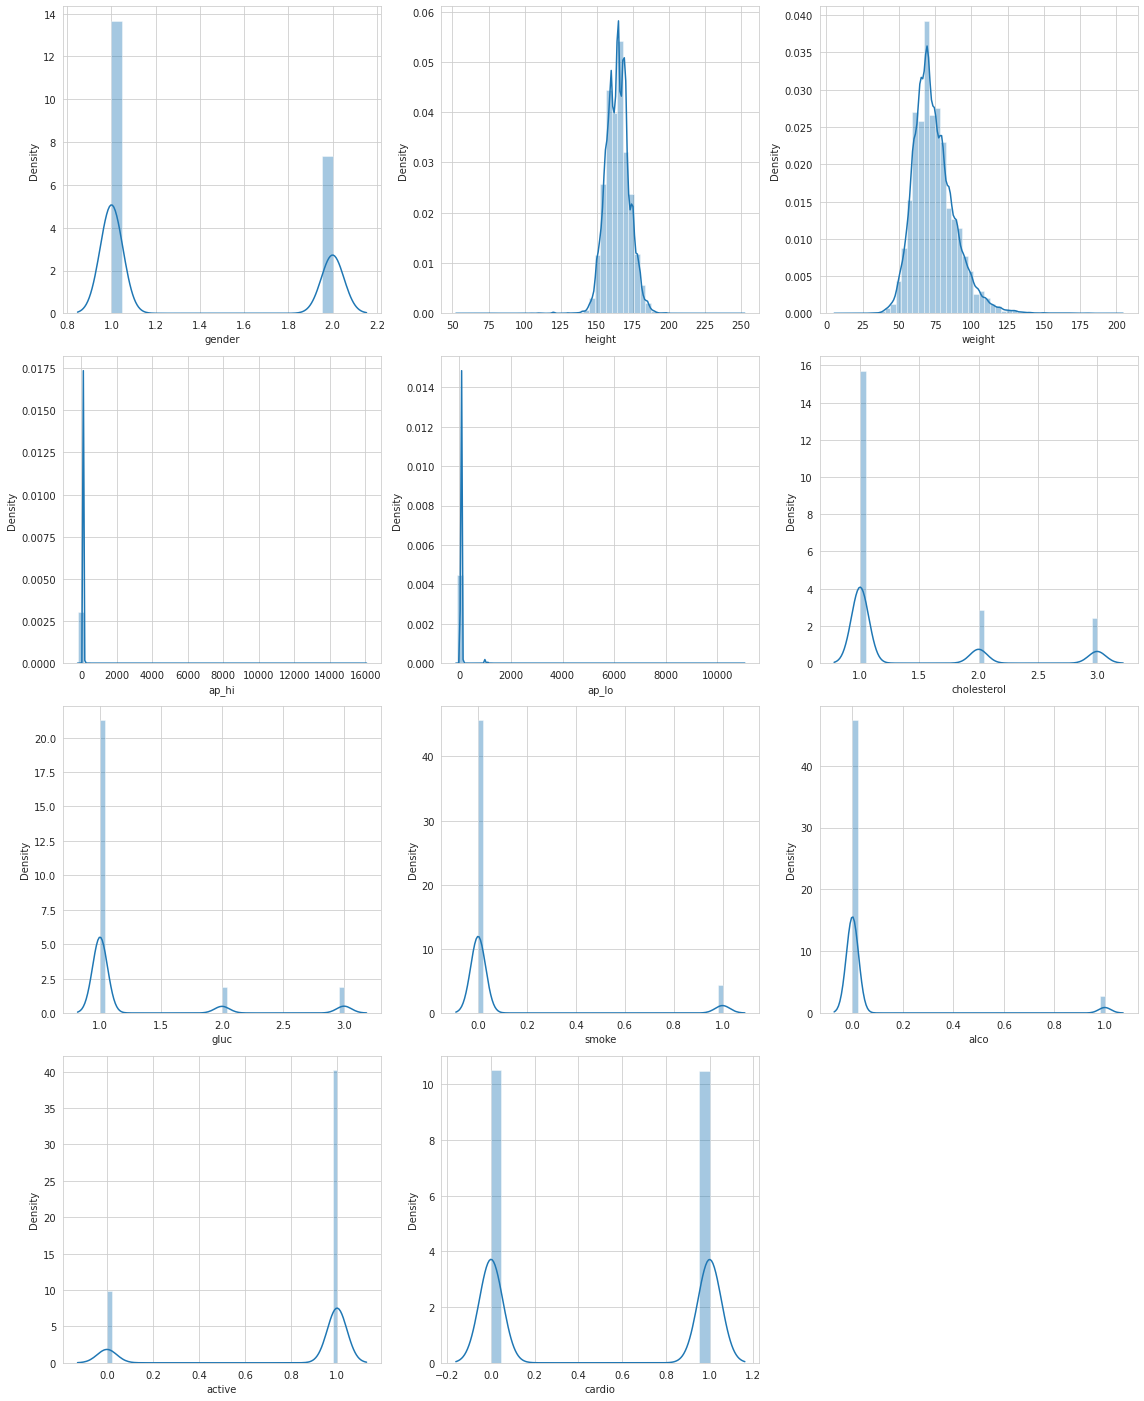

In [ ]:
# check distribution and skew
def check_dist(df):
    l = df.columns.values
    plt.figure(figsize=(16,24))
    for i in range(1,len(l)):
        plt.subplot(5,3,i)
        sns.distplot(df[l[i]],kde=True) 
        plt.tight_layout()
        
check_dist(df)

Histograms show the distribution of each feature in the dataset. There appears to be some variation in age, but height and weight are roughly normally distributed. However, the histograms further suggest the presence of outliers in the blood pressure features. Moreover, there exist categorical features in the dataset, such as gender, cholesterol, glucose, smoking habits, alcohol use, and activity.

### Check outliers

In [ ]:
#removing Outliers
# Let's remove, that fall below 2.5% or above 97.5% of a given range.
df.drop(df[(df['height'] > df['height'].quantile(0.975)) | (df['height'] < df['height'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) | (df['weight'] < df['weight'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['age'] > df['age'].quantile(0.975)) | (df['age'] < df['age'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.975)) | (df['ap_lo'] < df['ap_lo'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.975)) | (df['ap_hi'] < df['ap_hi'].quantile(0.025))].index,inplace=True)


In [ ]:
print(df.shape)

(57155, 12)


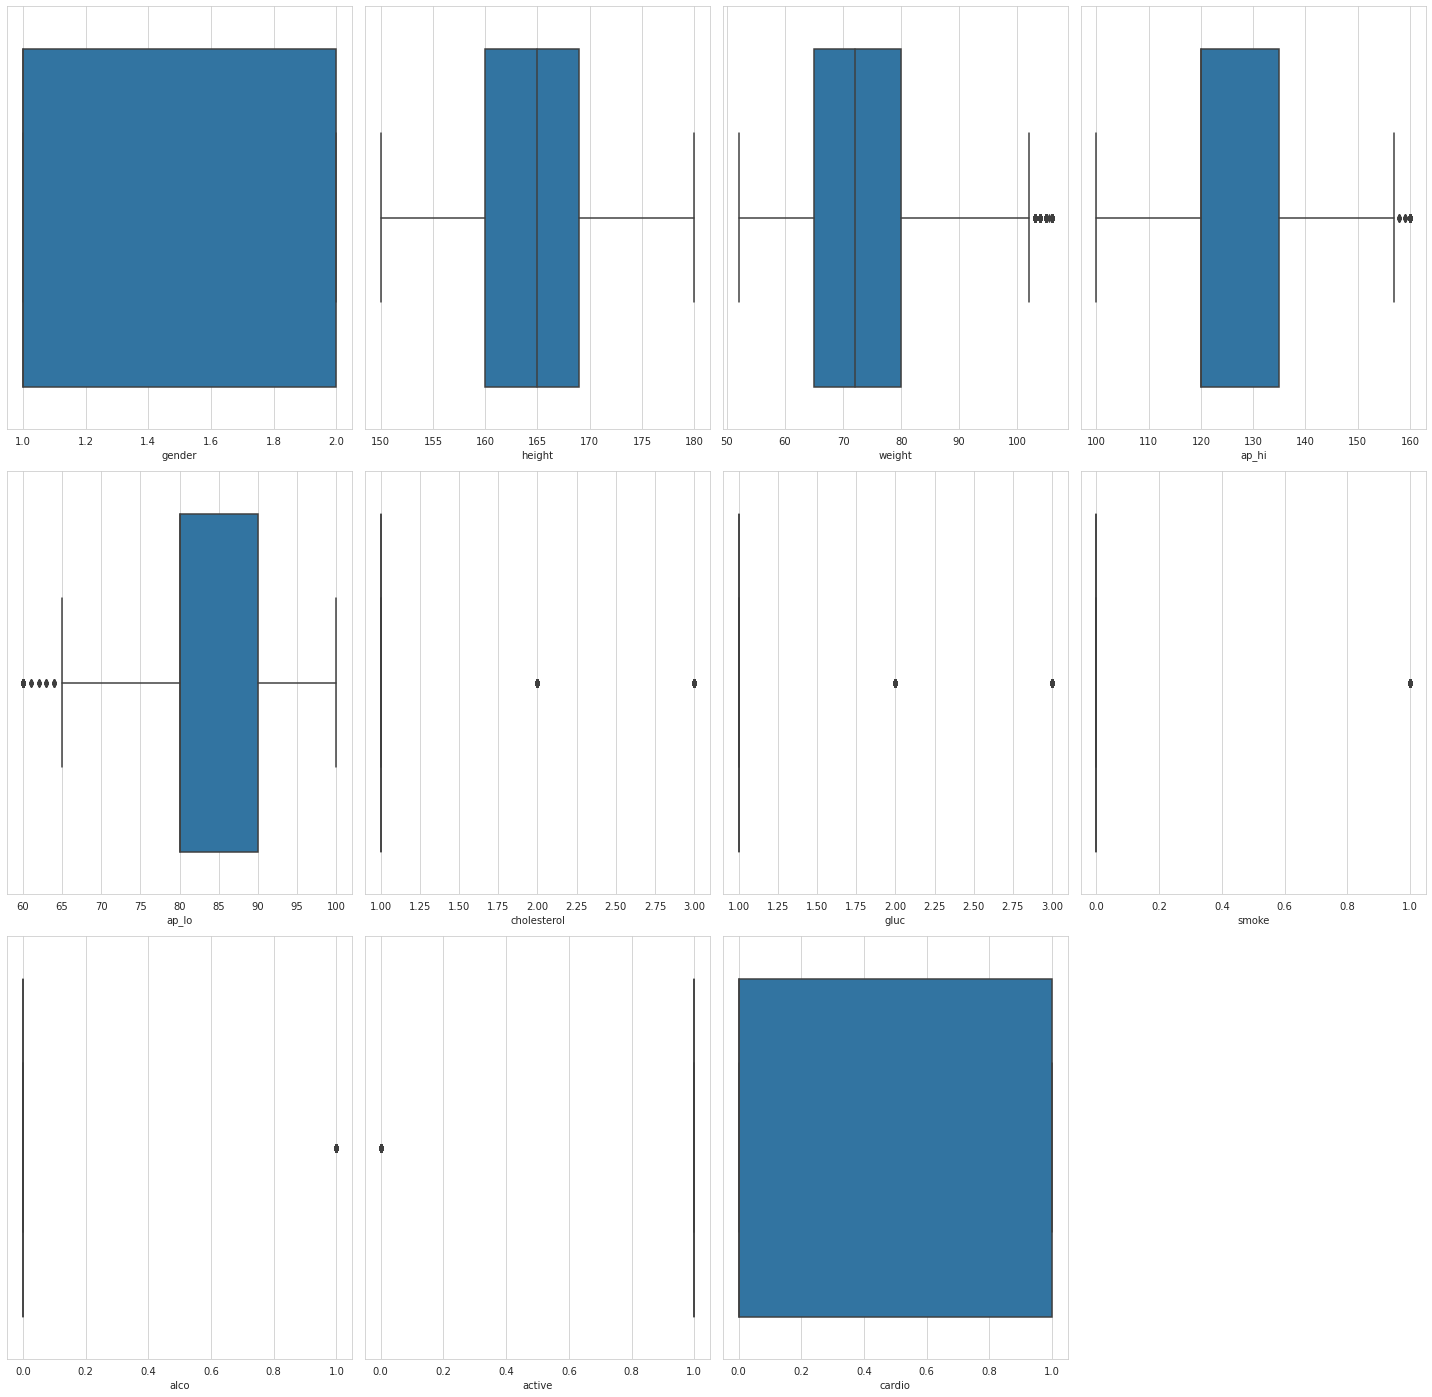

In [ ]:
check_outliers(df)

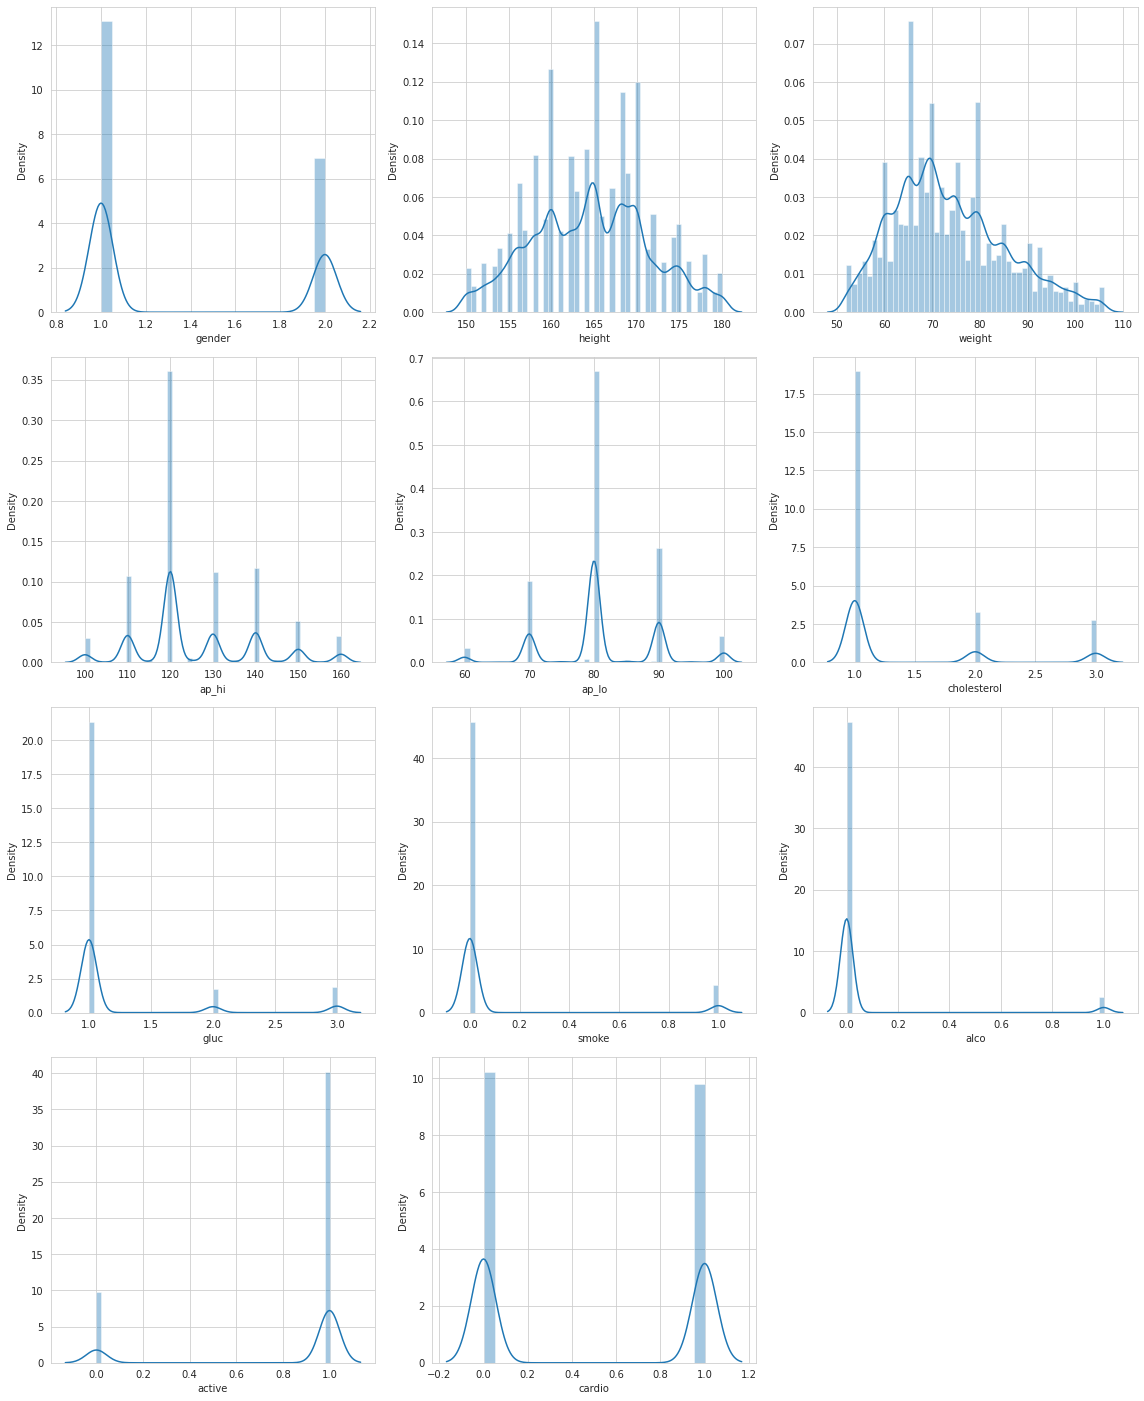

In [ ]:
check_dist(df)

## Transforming Data

#### Transforming the column Age

In [ ]:
# transforming the column AGE(measured in days) for Years
df['years'] = (df['age'] / 365).round().astype('int')
df.drop(['age'], axis='columns', inplace=True)


In [ ]:
# age_bin in 5 years 
df['age_bin'] = pd.cut(df['years'], [0,20,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100], 
                              labels=['0-20', '20-30', '30-35', '35-40','40-45','45-50','50-55','55-60','60-65','65-70','70-75','75-80','80-85','85-90','90-95','95-100'])

#### Transforming the column bmi in Body Mass Index Classes (1 to 6)

In [ ]:
df['bmi'] = df['weight']/((df['height']/100)**2)

In [ ]:
rating = []
for row in df['bmi']:
    if row < 18.5 :    rating.append(1) #UnderWeight
    elif row > 18.5 and row  < 24.9:   rating.append(2)#NormalWeight
    elif row > 24.9 and row < 29.9:  rating.append(3)#OverWeight
    elif row > 29.9 and row < 34.9:  rating.append(4)#ClassObesity 1
    elif row > 34.9 and row < 39.9:  rating.append(5)#ClassObesity 2
    elif row > 39.9 and row < 49.9:  rating.append(6)#ClassObesity 3
        

In [ ]:
df['BMI_Class'] = rating


#### Creating the column MAP

Mean Arterial Pressure (MAP) = 2 Diastollic Blood Pressure + Sistolic Blood Pressure / 3


In [ ]:
df['MAP'] = ((2* df['ap_lo']) + df['ap_hi']) / 3

In [ ]:
map_values = []
for row in df['MAP']:
    if row < 70:    map_values.append(1) #Low
    elif row >= 70 and row  < 80:   map_values.append(2)#Normal
    elif row >= 80 and row < 90:  map_values.append(3)#Normal
    elif row >= 90 and row < 100:  map_values.append(4)#Normal
    elif row >= 100 and row < 110:  map_values.append(5)#High
    elif row >= 110 and row < 120:  map_values.append(6)#Normal
    elif row >= 120:  map_values.append(7)


In [ ]:
df['MAP'].min(),df['MAP'].max()

(73.33333333333333, 120.0)

In [ ]:
df['MAP_Class'] = map_values

# Exploratory Data Analysis

In [ ]:
# Compare target column with sex column
pd.crosstab(df.cardio, df.gender)

gender,1,2
cardio,,
0,19069,10139
1,18317,9630


In [ ]:
df['gender']-=1

In [ ]:
df_male = df.query("gender == 0")
df_female = df.query("gender == 1")

In [ ]:
df_cat = df[["gender","age_bin","BMI_Class","MAP_Class","cholesterol","gluc","smoke","alco","active","cardio"]]
df_cat

,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,alco,active,cardio
0,1,45-50,2,4,1,1,0,0,1,0
1,0,50-55,5,5,3,1,0,0,1,1
2,0,50-55,2,4,3,1,0,0,0,1
3,1,45-50,3,6,1,1,0,0,1,1
4,0,45-50,2,2,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
69993,0,50-55,2,5,1,1,0,0,1,1
69994,0,55-60,3,5,1,1,0,0,1,1
69995,1,50-55,3,4,1,1,1,0,1,0
69998,0,60-65,3,4,1,2,0,0,0,1


In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_cat = df_cat.apply(le.fit_transform)
df_cat

,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,alco,active,cardio
0,1,2,1,2,0,0,0,0,1,0
1,0,3,4,3,2,0,0,0,1,1
2,0,3,1,2,2,0,0,0,0,1
3,1,2,2,4,0,0,0,0,1,1
4,0,2,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
69993,0,3,1,3,0,0,0,0,1,1
69994,0,4,2,3,0,0,0,0,1,1
69995,1,3,2,2,0,0,1,0,1,0
69998,0,5,2,2,0,1,0,0,0,1


In [ ]:
df_male = df_cat.query("gender == 0")
df_female = df_cat.query("gender == 1")

#### Making our crosstab visual

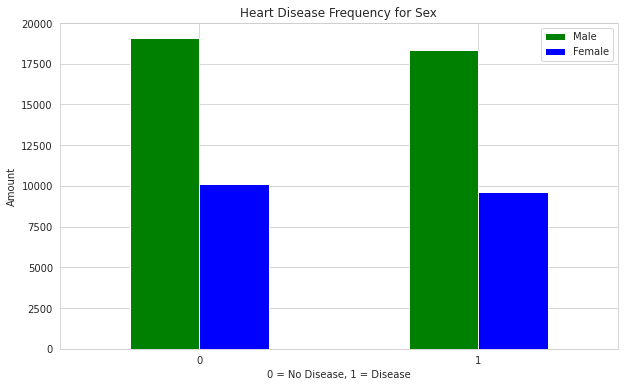

In [ ]:
# Create a plot
pd.crosstab(df.cardio, df.gender).plot(kind="bar", figsize=(10,6), color=["green", "blue"])

plt.title("Heart Disease Frequency for Sex")
plt.xlabel("0 = No Disease, 1 = Disease")
plt.ylabel("Amount")
plt.legend(["Male", "Female"])
plt.xticks(rotation=0); 

#### MAP Classes

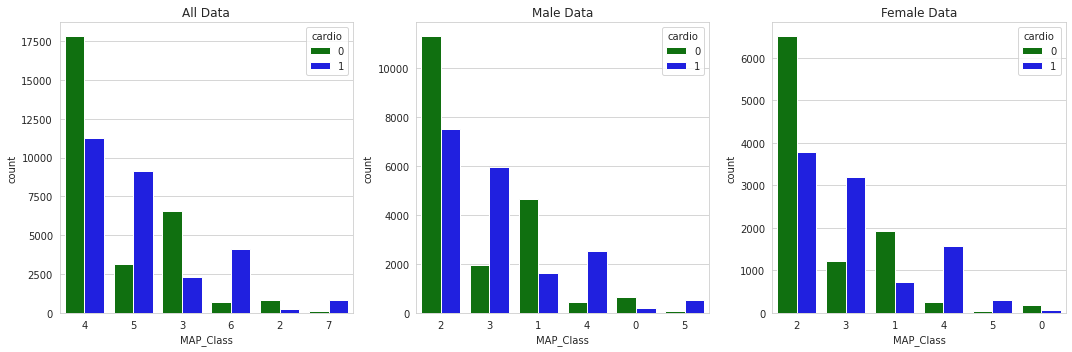

In [ ]:
fig, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df['MAP_Class'],order=df['MAP_Class'].value_counts().index,hue=df['cardio'],palette=['green',"blue"],ax=axs[0])
sns.countplot(x=df_male['MAP_Class'],order=df_male['MAP_Class'].value_counts().index,hue=df_male['cardio'],palette=['green',"blue"],ax=axs[1])
sns.countplot(x=df_female['MAP_Class'],order=df_female['MAP_Class'].value_counts().index,hue=df_female['cardio'],palette=['green',"blue"],ax=axs[2])

axs[0].set_title('All Data')
axs[1].set_title('Male Data')
axs[2].set_title('Female Data')
plt.tight_layout()
plt.show()

#### BMI Classes

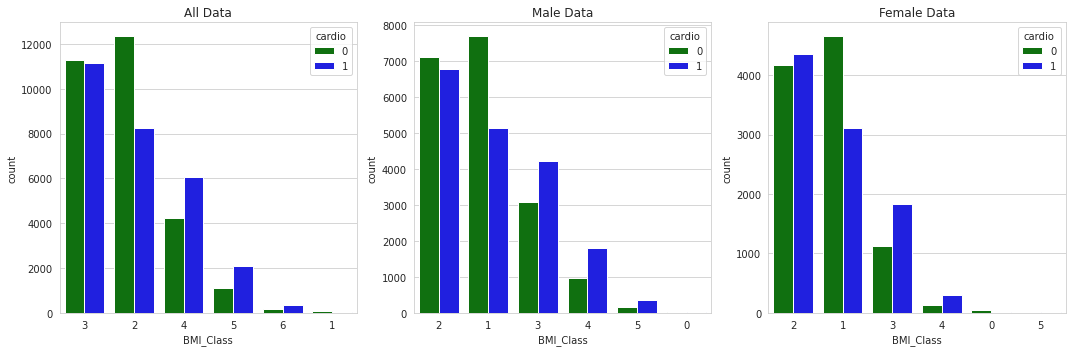

In [ ]:
fig, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df['BMI_Class'],order=df['BMI_Class'].value_counts().index,hue=df['cardio'],palette=['green',"blue"],ax=axs[0])
sns.countplot(x=df_male['BMI_Class'],order=df_male['BMI_Class'].value_counts().index,hue=df_male['cardio'],palette=['green',"blue"],ax=axs[1])
sns.countplot(x=df_female['BMI_Class'],order=df_female['BMI_Class'].value_counts().index,hue=df_female['cardio'],palette=['green',"blue"],ax=axs[2])

axs[0].set_title('All Data')
axs[1].set_title('Male Data')
axs[2].set_title('Female Data')
plt.tight_layout()
plt.show()

The BMI Classes for All data, Male and Female are very similar BUT the BMI_Class = 2 for Female data is slightly different

#### Glucose

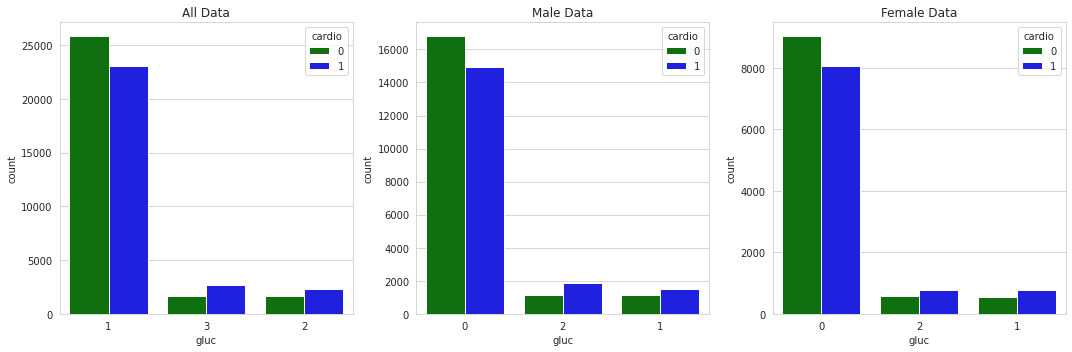

In [ ]:
fig, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df['gluc'],order=df['gluc'].value_counts().index,hue=df['cardio'],palette=['green',"blue"],ax=axs[0])
sns.countplot(x=df_male['gluc'],order=df_male['gluc'].value_counts().index,hue=df_male['cardio'],palette=['green',"blue"],ax=axs[1])
sns.countplot(x=df_female['gluc'],order=df_female['gluc'].value_counts().index,hue=df_female['cardio'],palette=['green',"blue"],ax=axs[2])

axs[0].set_title('All Data')
axs[1].set_title('Male Data')
axs[2].set_title('Female Data')
plt.tight_layout()
plt.show()

#### Cholesterol

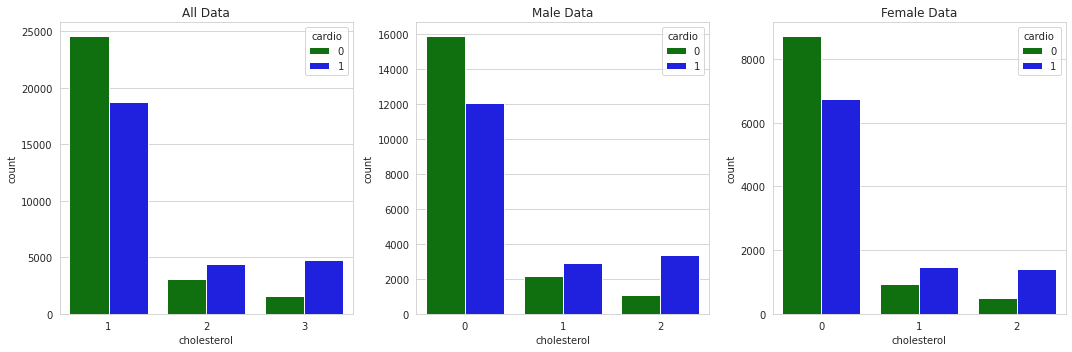

In [ ]:
fig, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df['cholesterol'],order=df['cholesterol'].value_counts().index,hue=df['cardio'],palette=['green',"blue"],ax=axs[0])
sns.countplot(x=df_male['cholesterol'],order=df_male['cholesterol'].value_counts().index,hue=df_male['cardio'],palette=['green',"blue"],ax=axs[1])
sns.countplot(x=df_female['cholesterol'],order=df_female['cholesterol'].value_counts().index,hue=df_female['cardio'],palette=['green',"blue"],ax=axs[2])

axs[0].set_title('All Data')
axs[1].set_title('Male Data')
axs[2].set_title('Female Data')
plt.tight_layout()
plt.show()

#### Smoke

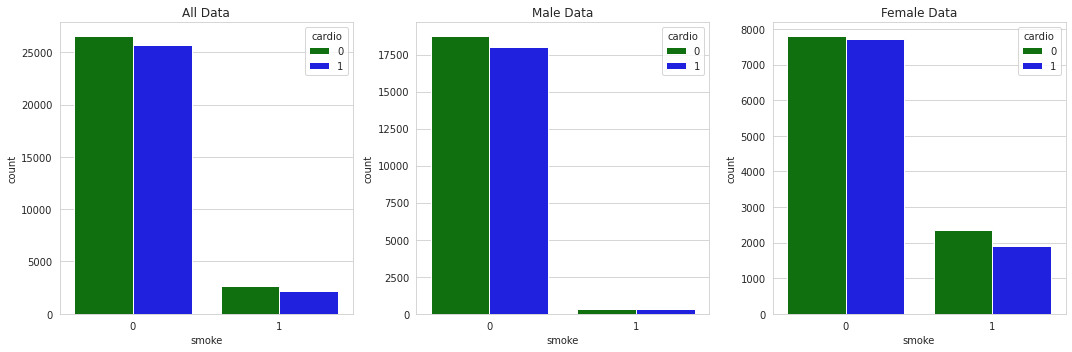

In [ ]:
fig, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df['smoke'],order=df['smoke'].value_counts().index,hue=df['cardio'],palette=['green',"blue"],ax=axs[0])
sns.countplot(x=df_male['smoke'],order=df_male['smoke'].value_counts().index,hue=df_male['cardio'],palette=['green',"blue"],ax=axs[1])
sns.countplot(x=df_female['smoke'],order=df_female['smoke'].value_counts().index,hue=df_female['cardio'],palette=['green',"blue"],ax=axs[2])

axs[0].set_title('All Data')
axs[1].set_title('Male Data')
axs[2].set_title('Female Data')
plt.tight_layout()
plt.show()

The value is high for Female data when smoke is 1

#### Active

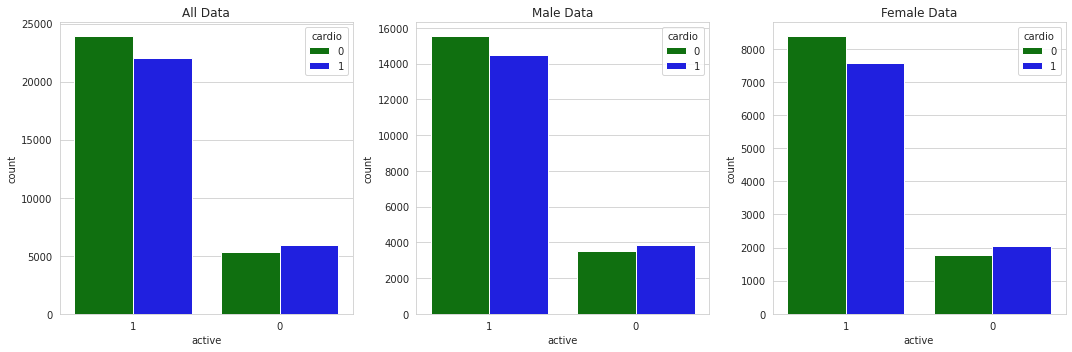

In [ ]:
fig, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df['active'],order=df['active'].value_counts().index,hue=df['cardio'],palette=['green',"blue"],ax=axs[0])
sns.countplot(x=df_male['active'],order=df_male['active'].value_counts().index,hue=df_male['cardio'],palette=['green',"blue"],ax=axs[1])
sns.countplot(x=df_female['active'],order=df_female['active'].value_counts().index,hue=df_female['cardio'],palette=['green',"blue"],ax=axs[2])

axs[0].set_title('All Data')
axs[1].set_title('Male Data')
axs[2].set_title('Female Data')
plt.tight_layout()
plt.show()

#### Alcohol

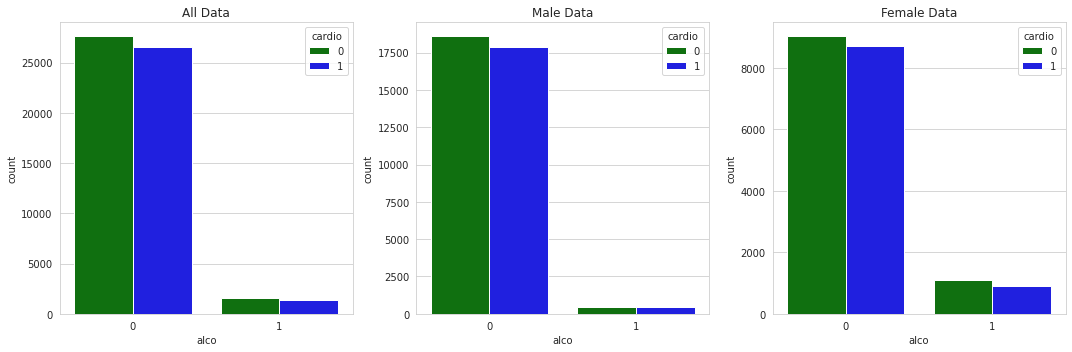

In [ ]:
fig, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df['alco'],order=df['alco'].value_counts().index,hue=df['cardio'],palette=['green',"blue"],ax=axs[0])
sns.countplot(x=df_male['alco'],order=df_male['alco'].value_counts().index,hue=df_male['cardio'],palette=['green',"blue"],ax=axs[1])
sns.countplot(x=df_female['alco'],order=df_female['alco'].value_counts().index,hue=df_female['cardio'],palette=['green',"blue"],ax=axs[2])

axs[0].set_title('All Data')
axs[1].set_title('Male Data')
axs[2].set_title('Female Data')
plt.tight_layout()
plt.show()

#### Age

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df[['age_bin']]= df[['age_bin']].apply(le.fit_transform)
df_male[['age_bin']]= df_male[['age_bin']].apply(le.fit_transform)
df_female[['age_bin']]= df_female[['age_bin']].apply(le.fit_transform)


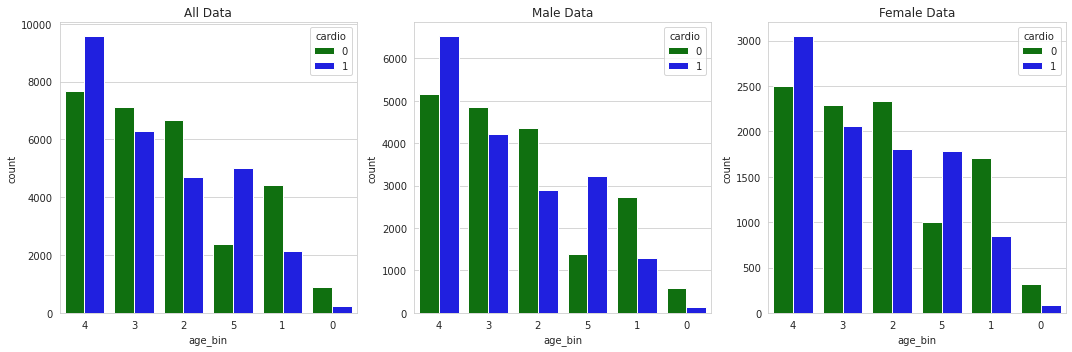

In [ ]:
fig, axs = plt.subplots(1,3,figsize = (15,5))
sns.countplot(x=df['age_bin'],order=df['age_bin'].value_counts().index,hue=df['cardio'],palette=['green',"blue"],ax=axs[0])
sns.countplot(x=df_male['age_bin'],order=df_male['age_bin'].value_counts().index,hue=df_male['cardio'],palette=['green',"blue"],ax=axs[1])
sns.countplot(x=df_female['age_bin'],order=df_female['age_bin'].value_counts().index,hue=df_female['cardio'],palette=['green',"blue"],ax=axs[2])

axs[0].set_title('All Data')
axs[1].set_title('Male Data')
axs[2].set_title('Female Data')
plt.tight_layout()
plt.show()

####  Visualizing ap_hi and ap_lo

Text(0.5, 1.0, 'Kernel Density of ap_lo')

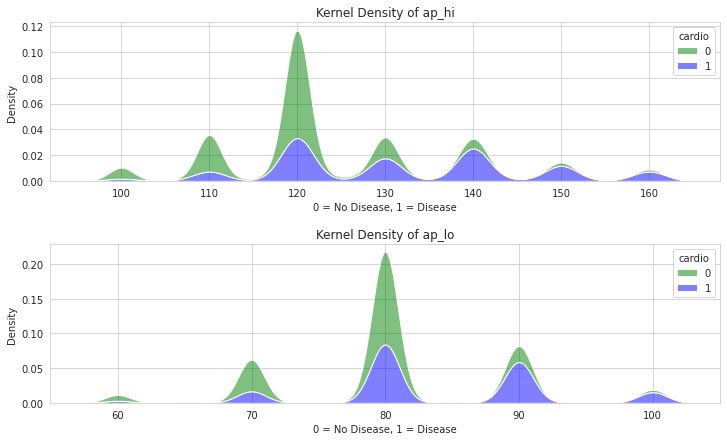

In [ ]:
# Visualizing ap_hi and ap_lo
fig = plt.figure(figsize = (12,7), constrained_layout = True)
gs = fig.add_gridspec(2,2)
plt.subplots_adjust(hspace = 0.4, wspace = 0.5)
palette = {0: 'Green', 1: 'Blue'}

# Density of ap_hi
ax1 = fig.add_subplot(gs[0, :2])
ax1 = sns.kdeplot(data =df, x = 'ap_hi', hue = 'cardio', alpha = 0.5, palette=palette, multiple = 'stack')
plt.xlabel("0 = No Disease, 1 = Disease")
ax1.set_title('Kernel Density of ap_hi')

# Density of ap_lo
ax2 = fig.add_subplot(gs[1,:2])
ax2 = sns.kdeplot(data =df, x = 'ap_lo', hue = 'cardio', alpha = 0.5, palette=palette, multiple = 'stack')
plt.xlabel("0 = No Disease, 1 = Disease")
ax2.set_title('Kernel Density of ap_lo')



Text(0.5, 1.0, 'ap_lo and ap_hi')

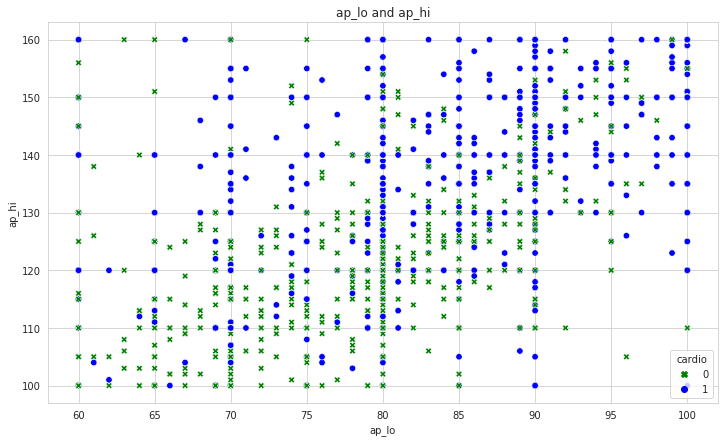

In [ ]:
#  Scatter plot to observe correlation between ap_hi and ap_lo
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (12,7))
plt.subplots_adjust(wspace = 0.4)

ax1 = sns.scatterplot(data = df, x = 'ap_lo', y = 'ap_hi', hue = 'cardio', palette = palette,style = 'cardio', markers = {0: 'X', 1: 'o'}, s = 40)
ax1.set_title('ap_lo and ap_hi')



If you have cardiovascular disease, your ap_hi and ap_lo tend to be higher. Also, the plot clearly indicates that there is a linear correlation between ap_hi and ap_lo.

In [ ]:
df['ap_hi'].corr(df['ap_lo'])

0.6969851787063998

In [ ]:
m_aphi = df['ap_hi'].mean()
m_aplo = df['ap_lo'].mean()

cardio_count = df[(df['ap_hi'] > m_aphi) & (df['ap_lo'] > m_aplo)].cardio.value_counts()
cardio_count / cardio_count.sum()

1    0.791761
0    0.208239
Name: cardio, dtype: float64

The probability of getting disease if you have higher ap_hi and ap_lo is 0.7987.

Text(0.5, 1.0, 'weight and ap_lo')

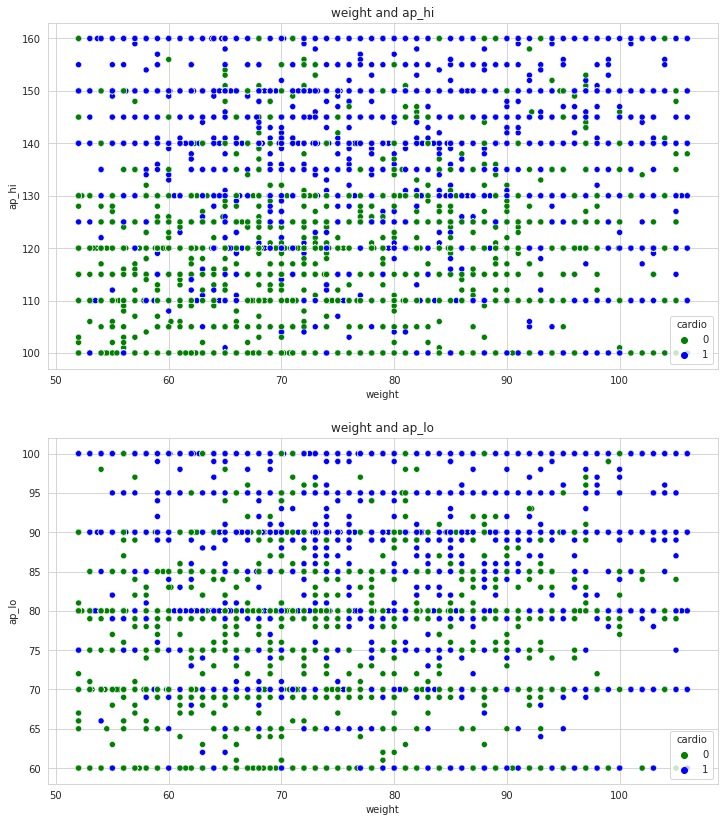

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12,14))
plt.subplots_adjust(wspace = 0.4)

ax1 = sns.scatterplot(data = df, x = 'weight', y = 'ap_hi', hue = 'cardio', palette = palette, ax = axes.flat[0])
ax1.set_title('weight and ap_hi')

ax2 = sns.scatterplot(data = df, x = 'weight', y = 'ap_lo', hue = 'cardio', palette = palette, ax = axes.flat[1])
ax2.set_title('weight and ap_lo')



It is clear that a major of people who have cardiovascular disease weigh more and have higher ap_hi and ap_lo.

In [ ]:
mean_weight = df['weight'].mean()
weight_and_aphi = df[(df['weight'] > mean_weight) & (df['ap_hi'] > m_aphi)].cardio.value_counts()
weight_and_aplo = df[(df['weight'] > mean_weight) & (df['ap_lo'] > m_aplo)].cardio.value_counts()
weight_aphi_aplo = df[(df['weight'] > mean_weight) & (df['ap_hi'] > m_aphi) & (df['ap_lo'] > m_aplo)].cardio.value_counts()

print('For people who weigh more and have higher ap_hi:')
print(weight_and_aphi / weight_and_aphi.sum())
print('---------------------------------------\n')

print('For people who weigh more and have higher ap_lo:')
print(weight_and_aplo / weight_and_aplo.sum())
print('---------------------------------------\n')

print('For people who weigh more as well as have higher ap_hi and ap_lo:')
print(weight_aphi_aplo / weight_aphi_aplo.sum())

For people who weigh more and have higher ap_hi:
1    0.758231
0    0.241769
Name: cardio, dtype: float64
---------------------------------------

For people who weigh more and have higher ap_lo:
1    0.767865
0    0.232135
Name: cardio, dtype: float64
---------------------------------------

For people who weigh more as well as have higher ap_hi and ap_lo:
1    0.794844
0    0.205156
Name: cardio, dtype: float64


## KModes Analysis

In [ ]:
df_cat.head()

,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,alco,active,cardio
0,1,2,1,2,0,0,0,0,1,0
1,0,3,4,3,2,0,0,0,1,1
2,0,3,1,2,2,0,0,0,0,1
3,1,2,2,4,0,0,0,0,1,1
4,0,2,1,0,0,0,0,0,0,0


In [ ]:
df_male.head()

,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,alco,active,cardio
1,0,3,4,3,2,0,0,0,1,1
2,0,3,1,2,2,0,0,0,0,1
4,0,2,1,0,0,0,0,0,0,0
5,0,4,2,2,1,1,0,0,0,0
6,0,5,4,2,2,0,0,0,1,0


In [ ]:
df_female.head()

,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,alco,active,cardio
0,1,2,1,2,0,0,0,0,1,0
3,1,2,2,4,0,0,0,0,1,1
7,1,5,3,3,2,2,0,0,1,1
11,1,3,1,2,0,0,0,0,1,0
12,1,1,1,2,0,0,0,0,0,0


##### Elbow Curve Method

In [ ]:
!pip install kmodes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from kmodes.kmodes import KModes


In [ ]:
# Elbow curve to find optimal K in Huang init
cost = []
K = range(1,6)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 5, verbose=0)
    kmode.fit_predict(df_cat)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
cost = []
K = range(1,6)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 5, verbose=0)
    kmode.fit_predict(df_male)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()


The best number os clusters for male Data in Huang Init is 2

In [ ]:
cost = []
K = range(1,6)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 5, verbose=0)
    kmode.fit_predict(df_female)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

The best number of clusters for female data is 2

The best number of Clusters for All Data, Male and Female Data is 2 Clusters

#### Building the model with using K-Mode with "Huang" initialization

In [ ]:
# female data
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 10, verbose=1)
clusters_huang_1 = km_huang.fit_predict(df_female)
clusters_huang_1

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3781, cost: 50058.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 9405, cost: 50646.0
Run 2, iteration: 2/100, moves: 2142, cost: 50646.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 5445, cost: 50058.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 2116, cost: 57566.0
Run 4, iteration: 2/100, moves: 122, cost: 57566.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 5005, cost: 50646.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 3404, cost: 50035.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, 

array([0, 1, 1, ..., 1, 0, 0], dtype=uint16)

In [ ]:
# male data
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 10, verbose=1)
clusters_huang_2 = km_huang.fit_predict(df_male)
clusters_huang_2

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10403, cost: 89488.0
Run 1, iteration: 2/100, moves: 1352, cost: 89488.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 2961, cost: 101113.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 8081, cost: 88595.0
Run 3, iteration: 2/100, moves: 1581, cost: 88595.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 10673, cost: 91776.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 11952, cost: 90282.0
Run 5, iteration: 2/100, moves: 1575, cost: 90282.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 11310, cost: 89553.0
Init: initializing centroids
Init: initializing

array([0, 1, 1, ..., 0, 0, 0], dtype=uint16)

In [ ]:
#Inserting clusters in DataFrame
df_female.insert(0,"Cluster", clusters_huang_1, True)


In [ ]:
df_male.insert(0, "Cluster", clusters_huang_2, True)


In [ ]:
# replacing cluster column values to merge dataframes after
df_male["Cluster"].replace({0:3, 1:4, 2:5}, inplace=True)

In [ ]:
# merging female and male data
df_clusters = pd.concat([df_female, df_male], ignore_index=True, sort=False)
df_clusters

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,alco,active,cardio
0,0,1,2,1,2,0,0,0,0,1,0
1,1,1,2,2,4,0,0,0,0,1,1
2,1,1,5,3,3,2,2,0,0,1,1
3,0,1,3,1,2,0,0,0,0,1,0
4,0,1,1,1,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
57150,3,0,4,2,3,1,1,0,0,1,0
57151,4,0,3,1,3,0,0,0,0,1,1
57152,3,0,4,2,3,0,0,0,0,1,1
57153,3,0,5,2,2,0,1,0,0,0,1


In [ ]:
df_female = df_female.drop('Cluster',axis=1)

#### Correlation Matrix 

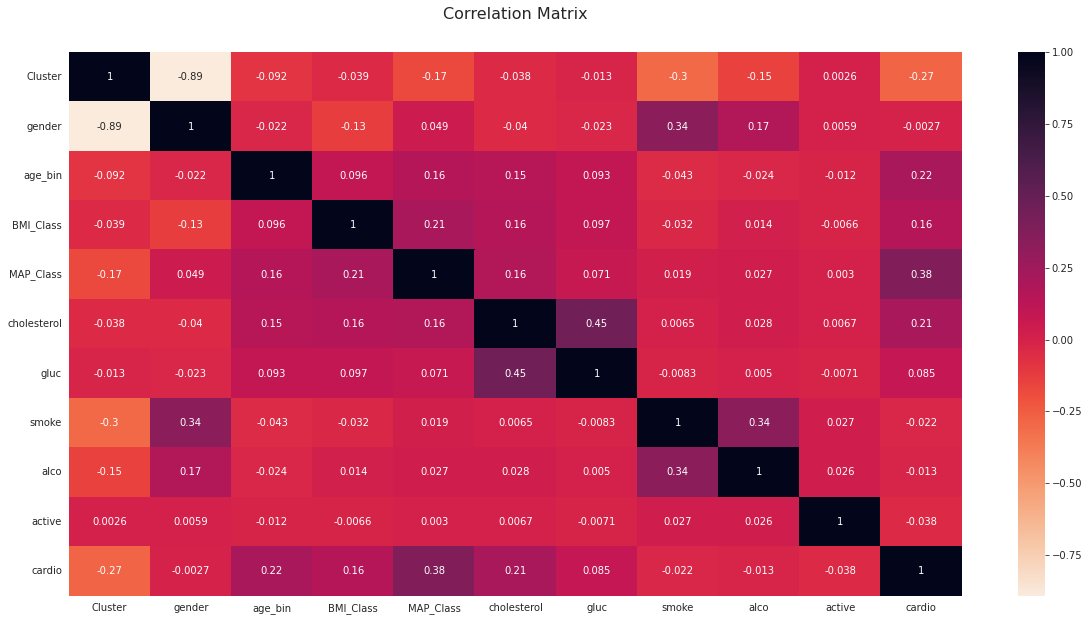

In [ ]:
plt.figure(figsize = (20, 10))
plt.title('Correlation Matrix', fontsize = 16, y = 1.05)
  
sns.heatmap(df_clusters.corr(), annot = True, cmap = 'rocket_r');

## Preparing the Data for the Model

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_ml = df_clusters.apply(le.fit_transform)
df_ml

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,alco,active,cardio
0,0,1,2,1,2,0,0,0,0,1,0
1,1,1,2,2,4,0,0,0,0,1,1
2,1,1,5,3,3,2,2,0,0,1,1
3,0,1,3,1,2,0,0,0,0,1,0
4,0,1,1,1,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
57150,2,0,4,2,3,1,1,0,0,1,0
57151,3,0,3,1,3,0,0,0,0,1,1
57152,2,0,4,2,3,0,0,0,0,1,1
57153,2,0,5,2,2,0,1,0,0,0,1


# Preparing the Data for the Model


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,recall_score
df_ml= df_ml.dropna()
X = df_ml.drop('cardio', axis=1)
y = df_ml['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80% training and 20% test

In [ ]:
def evaluate_model(clf, X_test, y_test):

    # predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy:",accuracy_score(y_test, y_pred))

    # precision: what percentage of positive tuples are labeled as such?
    print("Precision:",precision_score(y_test, y_pred))

    # recall: what percentage of positive tuples are labelled as such?
    print("Recall:",recall_score(y_test, y_pred))
    

## Training the Model using Different Algorithms¶


#### Multi Layer Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(45,15),activation='relu',alpha=0.0001,
                    random_state=5,max_iter=500,
                    verbose=True,power_t=0.5,
                    learning_rate_init=0.02)

mlp.fit(X_train,y_train)


Iteration 1, loss = 0.47582557
Iteration 2, loss = 0.36433835
Iteration 3, loss = 0.33333499
Iteration 4, loss = 0.31405987
Iteration 5, loss = 0.30351794
Iteration 6, loss = 0.29607092
Iteration 7, loss = 0.29124707
Iteration 8, loss = 0.28437065
Iteration 9, loss = 0.28283791
Iteration 10, loss = 0.27739309
Iteration 11, loss = 0.27559626
Iteration 12, loss = 0.27868207
Iteration 13, loss = 0.27657211
Iteration 14, loss = 0.27300445
Iteration 15, loss = 0.27351373
Iteration 16, loss = 0.27308492
Iteration 17, loss = 0.27143999
Iteration 18, loss = 0.27280006
Iteration 19, loss = 0.27286816
Iteration 20, loss = 0.27167605
Iteration 21, loss = 0.27433054
Iteration 22, loss = 0.27314455
Iteration 23, loss = 0.27423259
Iteration 24, loss = 0.27295938
Iteration 25, loss = 0.27006245
Iteration 26, loss = 0.27200761
Iteration 27, loss = 0.26997349
Iteration 28, loss = 0.27016363
Iteration 29, loss = 0.27126806
Iteration 30, loss = 0.26776968
Iteration 31, loss = 0.26948952
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(45, 15), learning_rate_init=0.02,
              max_iter=500, random_state=5, verbose=True)

In [ ]:
evaluate_model(mlp, X_test, y_test)

Accuracy: 0.869477735981104
Precision: 0.8903276437119875
Recall: 0.8294644489124474


In [ ]:
cv_metrics = pd.DataFrame({"Accuracy": np.mean(cross_val_score(mlp,X,y,cv=5,scoring="accuracy")),
                            "Precision": np.mean(cross_val_score(mlp,X,y,cv=5,scoring="precision")),
                            "Recall": np.mean(cross_val_score(mlp,X,y,cv=5,scoring="recall")),
                            "F1": np.mean(cross_val_score(mlp,X,y,cv=5,scoring="f1"))},
                          index=[0])

Iteration 1, loss = 0.46640636
Iteration 2, loss = 0.35547774
Iteration 3, loss = 0.31582170
Iteration 4, loss = 0.29741977
Iteration 5, loss = 0.29381621
Iteration 6, loss = 0.28405840
Iteration 7, loss = 0.28163685
Iteration 8, loss = 0.27614745
Iteration 9, loss = 0.27833637
Iteration 10, loss = 0.28041729
Iteration 11, loss = 0.27978845
Iteration 12, loss = 0.27431015
Iteration 13, loss = 0.27038121
Iteration 14, loss = 0.27184882
Iteration 15, loss = 0.27053484
Iteration 16, loss = 0.26794420
Iteration 17, loss = 0.26819605
Iteration 18, loss = 0.26758433
Iteration 19, loss = 0.26705675
Iteration 20, loss = 0.26756462
Iteration 21, loss = 0.26991901
Iteration 22, loss = 0.26865790
Iteration 23, loss = 0.26473913
Iteration 24, loss = 0.26618080
Iteration 25, loss = 0.26731595
Iteration 26, loss = 0.26267611
Iteration 27, loss = 0.26373132
Iteration 28, loss = 0.26357471
Iteration 29, loss = 0.26134323
Iteration 30, loss = 0.26516650
Iteration 31, loss = 0.26299806
Iteration 32, los

In [ ]:
cv_metrics

,Accuracy,Precision,Recall,F1
0,0.872837,0.887073,0.848534,0.8671


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


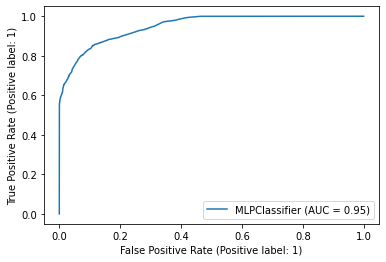

In [ ]:
plot_roc_curve(mlp, X_test, y_test)

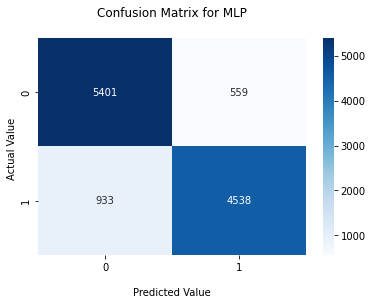

In [ ]:
y_pred = mlp.predict(X_test)
matrix = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(matrix,annot=True,cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix for MLP\n');
ax.set_xlabel('\nPredicted Value')
ax.set_ylabel('Actual Value ');
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      5960
           1       0.89      0.83      0.86      5471

    accuracy                           0.87     11431
   macro avg       0.87      0.87      0.87     11431
weighted avg       0.87      0.87      0.87     11431



### RandomForestClassifer

In [ ]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train,y_train)
evaluate_model(random_forest, X_test, y_test)

Accuracy: 0.8648412212404863
Precision: 0.8930501930501931
Recall: 0.8235713014064447


In [ ]:
random_forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid={ 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}, cv= 5).fit(X_train, y_train)

In [ ]:
random_forest.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 500}

In [ ]:
random_forest = RandomForestClassifier(criterion='gini',
 max_depth= 20,
 max_features='log2',
 n_estimators=500)
random_forest.fit(X_train,y_train)
evaluate_model(random_forest, X_test, y_test)

Accuracy: 0.8690403289301023
Precision: 0.8852268321054673
Recall: 0.8345823432644854


In [ ]:
random_forest = RandomForestClassifier(criterion='gini', max_depth= 20,
                                       max_features='log2',n_estimators=500)

random_forest.fit(X_train,y_train)
evaluate_model(random_forest, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


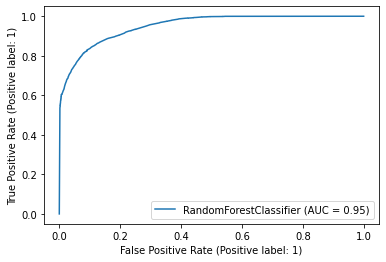

In [ ]:
plot_roc_curve(random_forest, X_test, y_test)

In [ ]:
cv_metrics = pd.DataFrame({"Accuracy": np.mean(cross_val_score(random_forest,X,y,cv=5,scoring="accuracy")),
                            "Precision": np.mean(cross_val_score(random_forest,X,y,cv=5,scoring="precision")),
                            "Recall": np.mean(cross_val_score(random_forest,X,y,cv=5,scoring="recall")),
                            "F1": np.mean(cross_val_score(random_forest,X,y,cv=5,scoring="f1"))},
                          index=[0])

In [ ]:
cv_metrics

,Accuracy,Precision,Recall,F1
0,0.870528,0.894248,0.834365,0.863247


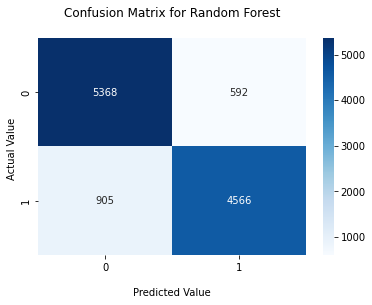

In [ ]:
y_pred = random_forest.predict(X_test)
matrix = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(matrix,annot=True,cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix for Random Forest\n');
ax.set_xlabel('\nPredicted Value')
ax.set_ylabel('Actual Value ');
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      5960
           1       0.89      0.83      0.86      5471

    accuracy                           0.87     11431
   macro avg       0.87      0.87      0.87     11431
weighted avg       0.87      0.87      0.87     11431



### Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train,y_train)
evaluate_model(decision_tree, X_test, y_test)

Accuracy: 0.8653661097016884
Precision: 0.9009405643386031
Recall: 0.8117562206996033


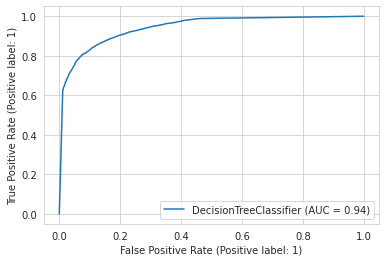

In [ ]:
plot_roc_curve(decision_tree, X_test, y_test)

In [ ]:
cv_metrics = pd.DataFrame({"Accuracy": np.mean(cross_val_score(decision_tree,X,y,cv=5,scoring="accuracy")),
                            "Precision": np.mean(cross_val_score(decision_tree,X,y,cv=5,scoring="precision")),
                            "Recall": np.mean(cross_val_score(decision_tree,X,y,cv=5,scoring="recall")),
                            "F1": np.mean(cross_val_score(decision_tree,X,y,cv=5,scoring="f1"))},
                          index=[0])

In [ ]:
cv_metrics

,Accuracy,Precision,Recall,F1
0,0.863774,0.895822,0.816115,0.854194


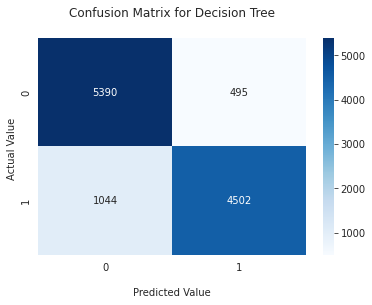

In [ ]:
y_pred = decision_tree.predict(X_test)
matrix = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(matrix,annot=True,cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix for Decision Tree\n');
ax.set_xlabel('\nPredicted Value')
ax.set_ylabel('Actual Value ');
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      5885
           1       0.90      0.81      0.85      5546

    accuracy                           0.87     11431
   macro avg       0.87      0.86      0.86     11431
weighted avg       0.87      0.87      0.86     11431



### X Gradient Boost

In [ ]:
from xgboost import XGBClassifier
xg_boost = XGBClassifier()
xg_boost.fit(X_train,y_train)
evaluate_model(xg_boost,X_test,y_test)

Accuracy: 0.8644912955996851
Precision: 0.8638640429338104
Recall: 0.8597115898166281


In [ ]:
xg_boost = XGBClassifier(verbosity=0, seed=1, n_estimators=150,
                            gamma= 0.3, max_depth=20, learning_rate=0.2,
                            reg_lambda=100, scale_pos_weight=1)

xg_boost.fit(X_train, y_train)
evaluate_model(xg_boost, X_test, y_test)

Accuracy: 0.8701775872627067
Precision: 0.8962607861936721
Recall: 0.8321167883211679


In [ ]:
0.8962607861936721*2*0.8321167883211679/(0.8321167883211679+0.8962607861936721)

0.8629985228951256

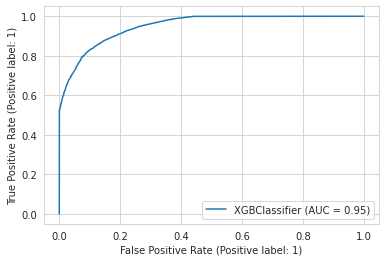

In [ ]:
plot_roc_curve(xg_boost, X_test, y_test)

In [ ]:
cv_metrics = pd.DataFrame({"Accuracy": np.mean(cross_val_score(xg_boost,X,y,cv=5,scoring="accuracy")),
                            "Precision": np.mean(cross_val_score(xg_boost,X,y,cv=5,scoring="precision")),
                            "Recall": np.mean(cross_val_score(xg_boost,X,y,cv=5,scoring="recall")),
                            "F1": np.mean(cross_val_score(xg_boost,X,y,cv=5,scoring="f1"))},
                          index=[0])

In [ ]:
cv_metrics

,Accuracy,Precision,Recall,F1
0,0.86869,0.889369,0.835725,0.861569


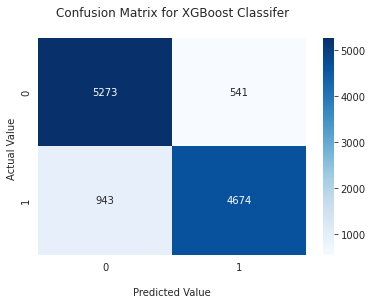

In [ ]:
y_pred = xg_boost.predict(X_test)
matrix = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(matrix,annot=True,cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix for XGBoost Classifer\n');
ax.set_xlabel('\nPredicted Value')
ax.set_ylabel('Actual Value ');
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      5814
           1       0.90      0.83      0.86      5617

    accuracy                           0.87     11431
   macro avg       0.87      0.87      0.87     11431
weighted avg       0.87      0.87      0.87     11431

